In [33]:
import dask.dataframe as dd#similar to pandas

import pandas as pd#pandas to create small dataframes 

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays

from matplotlib import rcParams#Size of plots  

import matplotlib.pylab as plt
import seaborn as sns#Plots

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [8]:
month = dd.read_parquet('/Users/jinsu/Desktop/vscode/yellow_tripdata_2020-01.parquet')
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


In [29]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    s = np.datetime_as_string(s, unit='s')
    # s = s.replace('T', ' ')
    s = s[0:10]+s[11:20]

    return time.mktime(datetime.datetime.strptime(s, '%Y-%m-%d%H:%M:%S').timetuple())



# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','PULocationID','DOLocationID','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame


#  passenger_count	trip_distance	pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude	total_amount	trip_times	pickup_times	Speed
#   1                  1.59	      -73.993896        	40.750111    	-73.974785      	40.750618           	17.05   	 18.050000	1.421329e+09	5.285319
#   1               	3.30    	-74.001648      	40.724243   	-73.994415      	40.759109           	17.80   	19.833333	1.420902e+09	9.983193
#   1               	1.80     	-73.963341      	40.802788     	-73.951820      	40.824413           	10.80   	10.050000	1.420902e+09	10.746269
#   1               	0.50    	-74.009087      	40.713818    	-74.004326       	40.719986           	4.80    	1.866667	1.420902e+09	16.071429
#   1               	3.00    	-73.971176      	40.762428    	-74.004181      	40.742653           	16.30   	19.316667	1.420902e+09	9.318378
frame_with_durations = return_with_trip_times(month)
print(frame_with_durations.head())

   passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              1.0            1.2           238           239         11.27   
1              1.0            1.2           239           238         12.30   
2              1.0            0.6           238           238         10.80   
3              1.0            0.8           238           151          8.16   
4              1.0            0.0           193           193          4.80   

   trip_times  pickup_times      Speed  
0    4.800000  1.577806e+09  15.000000  
1    7.416667  1.577807e+09   9.707865  
2    6.183333  1.577807e+09   5.822102  
3    4.850000  1.577808e+09   9.896907  
4    2.300000  1.577805e+09   0.000000  


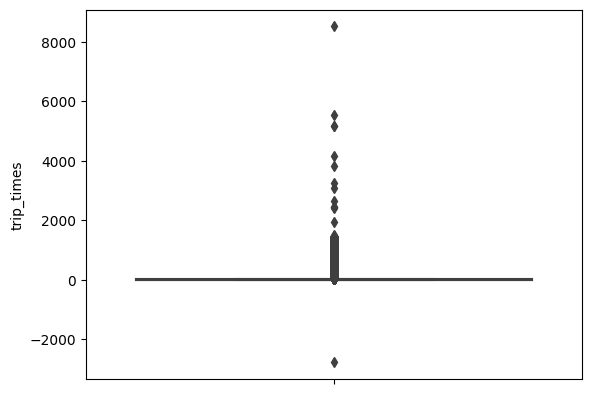

In [34]:
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

In [35]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -2770.366666666667
10 percentile value is 3.9833333333333334
20 percentile value is 5.616666666666666
30 percentile value is 7.133333333333334
40 percentile value is 8.716666666666667
50 percentile value is 10.483333333333333
60 percentile value is 12.55
70 percentile value is 15.166666666666666
80 percentile value is 18.9
90 percentile value is 25.616666666666667
100 percentile value is  8525.116666666667


In [36]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 25.616666666666667
91 percentile value is 26.716666666666665
92 percentile value is 27.95
93 percentile value is 29.333333333333332
94 percentile value is 31.0
95 percentile value is 33.05
96 percentile value is 35.65
97 percentile value is 39.06666666666667
98 percentile value is 44.15
99 percentile value is 53.43333333333333
100 percentile value is  8525.116666666667


In [59]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

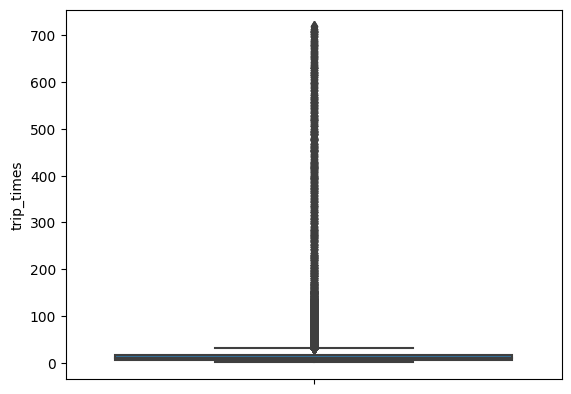

In [60]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

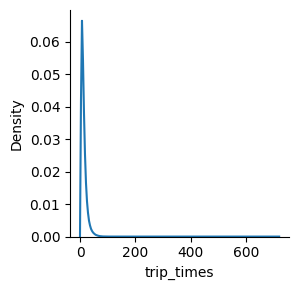

In [61]:
#pdf of trip-times after removing the outliers #size=6인거 지웠는데 무엇을 의미..?
sns.FacetGrid(frame_with_durations_modified) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend()
plt.show()

In [62]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

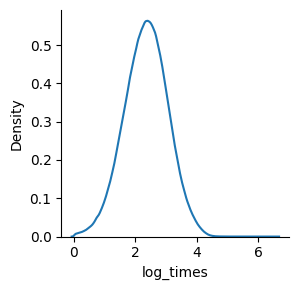

In [63]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified) \
      .map(sns.kdeplot,"log_times") \
      .add_legend()
plt.show()

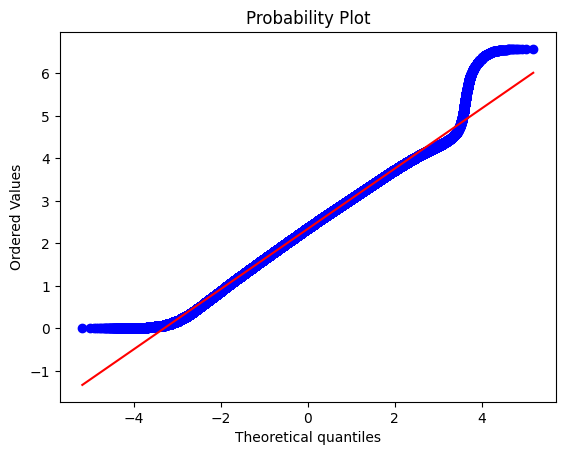

In [64]:
#Q-Q plot for checking if trip-times is log-normal
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

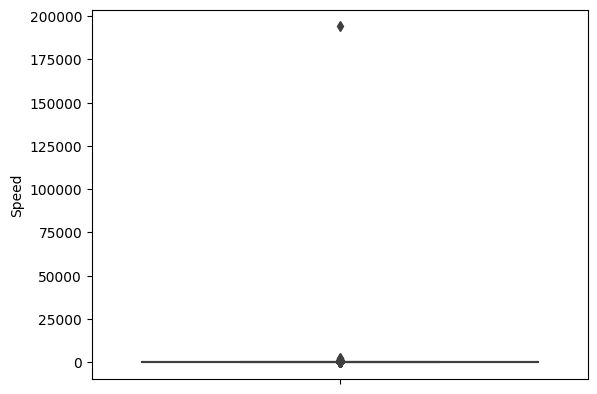

In [65]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [66]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -47.475
10 percentile value is 6.022304832713755
20 percentile value is 7.278688524590164
30 percentile value is 8.270270270270268
40 percentile value is 9.204545454545455
50 percentile value is 10.182136602451838
60 percentile value is 11.314285714285713
70 percentile value is 12.779999999999998
80 percentile value is 15.04017139796465
90 percentile value is 19.782372143634383
100 percentile value is  194067.75692307693


In [67]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 19.782372143634383
91 percentile value is 20.59259259259259
92 percentile value is 21.5
93 percentile value is 22.538860103626945
94 percentile value is 23.727272727272727
95 percentile value is 25.11917098445596
96 percentile value is 26.804758572428273
97 percentile value is 28.989858012170387
98 percentile value is 31.898734177215193
99 percentile value is 36.2608695652174
100 percentile value is  194067.75692307693


In [68]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 36.2608695652174
99.1 percentile value is 36.86440677966101
99.2 percentile value is 37.49480968858131
99.3 percentile value is 38.204081632653065
99.4 percentile value is 39.0
99.5 percentile value is 39.884892086330936
99.6 percentile value is 40.91493924231594
99.7 percentile value is 42.1978021978022
99.8 percentile value is 43.83673469387755
99.9 percentile value is 46.4
100 percentile value is  194067.75692307693


In [69]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<46.4)]

In [70]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

11.805962219936998

# trip distance

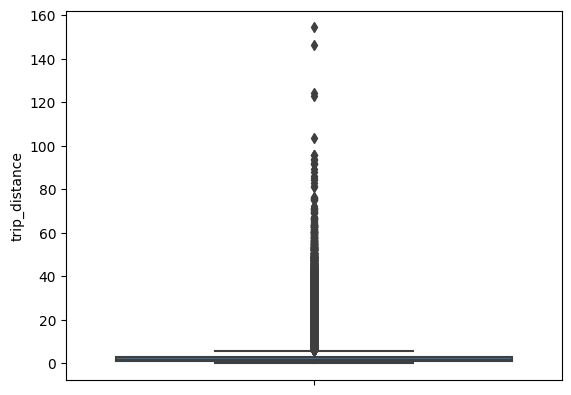

In [71]:
sns.boxplot(y="trip_distance", data=frame_with_durations_modified)
plt.show()

In [72]:
for i in range(0, 100, 10):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

0 percentile value is 0.01
10 percentile value is 0.64
20 percentile value is 0.88
30 percentile value is 1.1
40 percentile value is 1.32
50 percentile value is 1.61
60 percentile value is 2.0
70 percentile value is 2.54
80 percentile value is 3.56
90 percentile value is 6.68
100 percentile value is 154.45


In [73]:
for i in range(90, 100):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

90 percentile value is 6.68
91 percentile value is 7.3
92 percentile value is 8.04
93 percentile value is 8.82
94 percentile value is 9.7
95 percentile value is 10.79
96 percentile value is 12.4
97 percentile value is 15.52
98 percentile value is 17.56
99 percentile value is 19.04
100 percentile value is 154.45


In [74]:
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 19.04
99.1 percentile value is 19.29
99.2 percentile value is 19.53
99.3 percentile value is 19.84
99.4 percentile value is 20.2
99.5 percentile value is 20.6
99.6 percentile value is 21.06
99.7 percentile value is 21.66
99.8 percentile value is 22.9
99.9 percentile value is 26.69
100 percentile value is  154.45


In [75]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<27)]

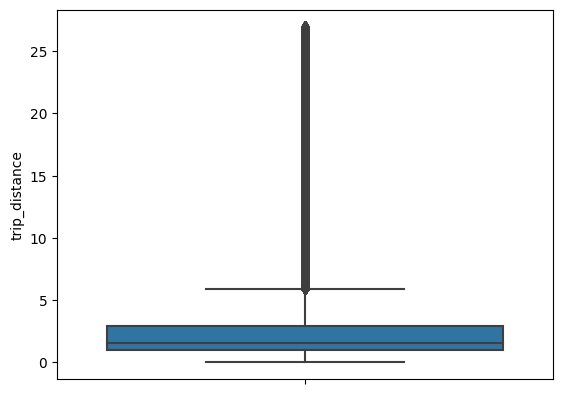

In [76]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

# total fare

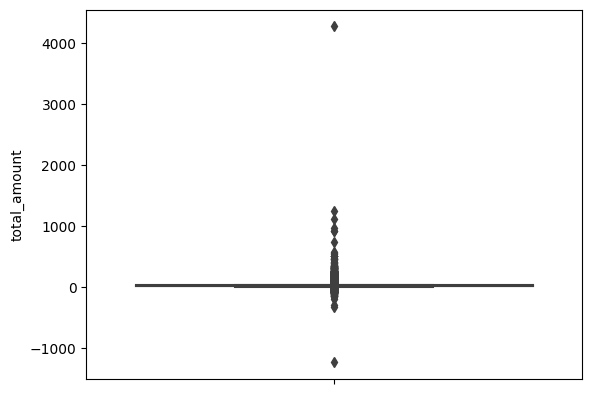

In [77]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [78]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -1242.3
10 percentile value is 9.3
20 percentile value is 10.56
30 percentile value is 11.76
40 percentile value is 12.96
50 percentile value is 14.3
60 percentile value is 15.96
70 percentile value is 18.3
80 percentile value is 21.95
90 percentile value is 31.31
100 percentile value is  4268.3


In [79]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 31.31
91 percentile value is 33.36
92 percentile value is 36.3
93 percentile value is 39.45
94 percentile value is 43.25
95 percentile value is 47.42
96 percentile value is 53.15
97 percentile value is 61.42
98 percentile value is 67.56
99 percentile value is 73.7
100 percentile value is  4268.3


In [80]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 73.7
99.1 percentile value is 73.7
99.2 percentile value is 74.9
99.3 percentile value is 76.77
99.4 percentile value is 76.92
99.5 percentile value is 79.1
99.6 percentile value is 79.42
99.7 percentile value is 82.4
99.8 percentile value is 89.55
99.9 percentile value is 102.06
100 percentile value is  4268.3


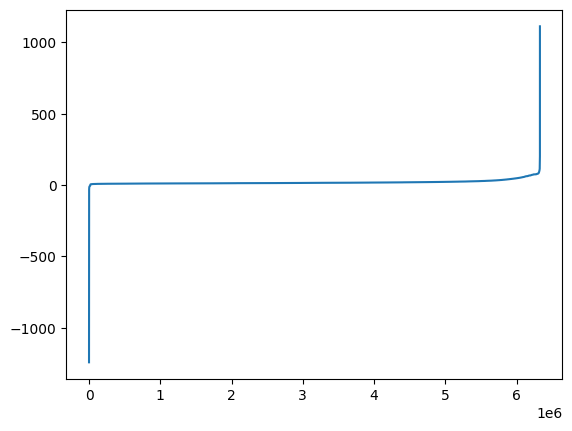

In [81]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

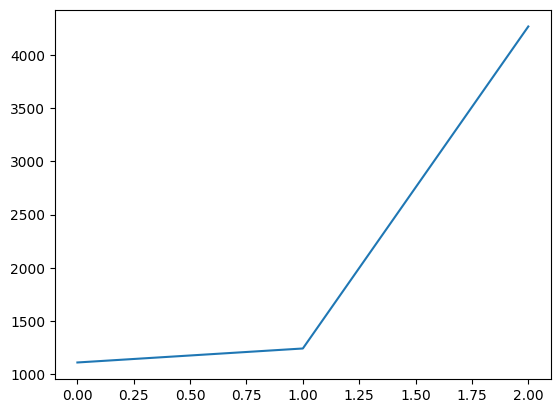

In [82]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

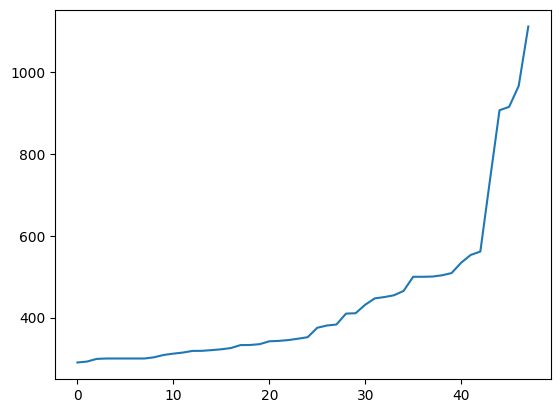

In [83]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()